# **The Stokes equations**
Emil Gestsson, using template by **Johan Hoffman**

# **Abstract**

This is a solution to lab 1: Viscous flow using the provided template solution to stokes equation.

Questions 1-3 and 5 have been solved.

# **Set up environment**

In [ ]:
# Load neccessary modules.
from google.colab import files

import numpy as np
import time

# Install FEniCS (this may take a long time)
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install-real.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

from dolfin import *; from mshr import *

import dolfin.common.plotting as fenicsplot

from matplotlib import pyplot as plt

# **Introduction**

Questions 1 and 2 can be solved using minor modifications to the example domain setup by first centering the hole and point where it is refined around, as well as setting the number of refines in the region to a non-zero number.

Question 3 is solved by creating an additional V function of the first order and comparing the results.

Question 5 is solved by adding the stabilization term from p36 of vt2023_lecture_2.pdf to the equation.

# **Method**

**Define domain and mesh**

In [3]:
# Define rectangular domain
L = 4
H = 2

# Generate mesh (examples with and without a hole in the mesh)
resolution = 32
mesh = generate_mesh(Rectangle(Point(0.0,0.0), Point(L,H)) - Circle(Point(0.5*L,0.5*H),0.2), resolution)

# Local mesh refinement (specified by a cell marker)
no_levels = 1
for i in range(0,no_levels):
  cell_marker = MeshFunction("bool", mesh, mesh.topology().dim())
  for cell in cells(mesh):
    cell_marker[cell] = False
    p = cell.midpoint()
    if p.distance(Point(0.5*L, 0.5*H)) < 1.0: # centered
        cell_marker[cell] = True
  mesh = refine(mesh, cell_marker)

**Define finite element approximation spaces**

In [17]:
# Generate mixed finite element spaces (for velocity and pressure)
def create_solution(v_degree, stabilized):
  VE = VectorElement("CG", mesh.ufl_cell(), v_degree)
  QE = FiniteElement("CG", mesh.ufl_cell(), 1)
  WE = VE * QE

  W = FunctionSpace(mesh, WE)
  V = FunctionSpace(mesh, VE)
  Q = FunctionSpace(mesh, QE)

  # Define trial and test functions
  w = Function(W)
  (u, p) = (as_vector((w[0],w[1])), w[2])
  (v, q) = TestFunctions(W)

  ## Define boundary conditions

  # Examples of inflow and outflow conditions
  XMIN = 0.0; XMAX = L
  YMIN = 0.0; YMAX = H
  uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, element = V.ufl_element())
  #pout = 0.0

  # Inflow boundary (ib), outflow boundary (ob) and wall boundary (wb)
  ib = Expression("near(x[0],XMIN) ? 1. : 0.", XMIN=XMIN, element = Q.ufl_element())
  ob = Expression("near(x[0],XMAX) ? 1. : 0.", XMAX=XMAX, element = Q.ufl_element())
  wb = Expression("x[0] > XMIN + DOLFIN_EPS && x[0] < XMAX - DOLFIN_EPS ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, element = Q.ufl_element())


  ## solve1
  h = CellDiameter(mesh)
  C = 1.0e3
  gamma = C/h

  f = Expression(("0.0","0.0"), element = V.ufl_element())

  # Define variational problem on residual form: r(u,p;v,q) = 0
  Cstab = 0.1
  residual = ( - p*div(v)*dx + inner(grad(u), grad(v))*dx + div(u)*q*dx +
               gamma*(ib*inner(u - uin, v) + wb*inner(u, v))*ds - inner(f, v)*dx
               + (Cstab*h*h*inner(grad(p), grad(q))*dx if stabilized else 0)) # new stabilization term

  solve(residual == 0, w)
  return project(u, V), project(p, Q)

# **Results**

**Refined Mesh (solving questions 1-2)**

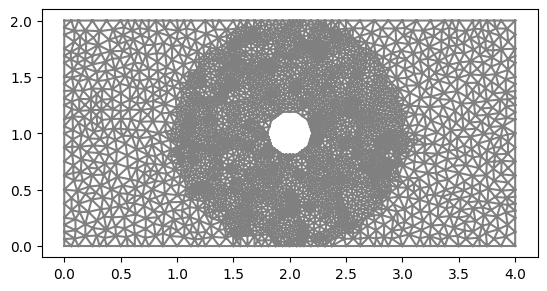

In [5]:
plt.figure()
plot(mesh)
plt.show()

**Create the different solutions for plotting**

In [ ]:
u1,p1 = create_solution(1, False)
u2,p2 = create_solution(1, True)
u3,p3 = create_solution(2, False)

**Comparing pressure for v of degree 1 and 2**

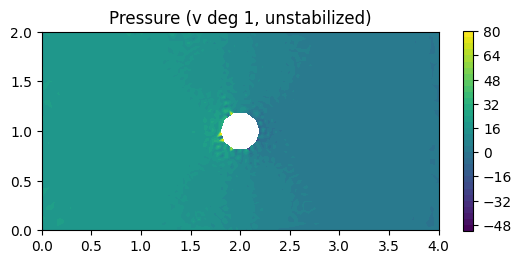

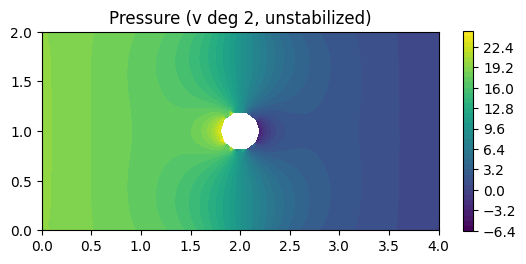

In [11]:
plt.figure()
c = plot(p1, title="Pressure (v deg 1, unstabilized)")
plt.colorbar(c, shrink=0.54)

plt.figure()
c = plot(p3, title="Pressure (v deg 2, unstabilized)")
plt.colorbar(c, shrink=0.54)

plt.show()

In the case where v and u had the same degree, we see that the failed stabiliy criteria manifests as points where the pressure explodes (in this case 4x and 8x on the respective max and min values).

**Pressure using Brezzi-Pitkäranta and v of degree 1**

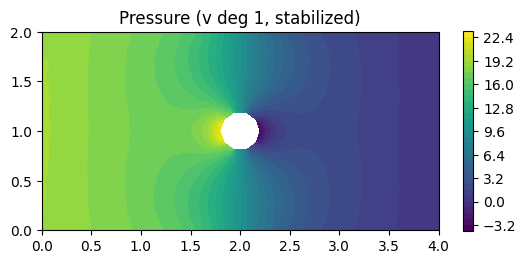

In [19]:
plt.figure()
c = plot(p2, title="Pressure (v deg 1, stabilized)")
plt.colorbar(c, shrink=0.54)
plt.show()

# **Discussion**

Here is a difference plot to highligt where the error in min/max is located

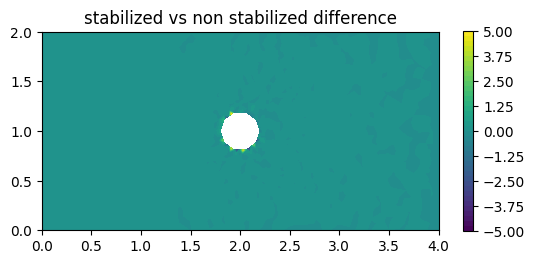

In [20]:
plt.figure()
c = plot(p3-p2, title="stabilized vs non stabilized difference")
plt.colorbar(c, shrink=0.54)
plt.show()

Which shows that most error in the stabilized version is likely caused by the unsmooth representation of the cylinder.